In [1]:
import cv2
import numpy as np
import sys
import get_supers
import object_track
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
%matplotlib inline

In [2]:
def getContrast(f):
    gray = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    return np.std(gray) + (0.3 * np.mean(gray)),np.mean(gray)

def getColour(f):
    (B, G, R) = cv2.split(f.astype("float"))
    rg = abs(R - G)
    yb = abs(0.5*(R + G) - B)
    stdRoot = np.sqrt((np.std(rg) ** 2) + (np.std(yb) ** 2))
    meanRoot = np.sqrt((np.mean(rg) ** 2) + (np.mean(yb) ** 2))
    return stdRoot + (0.3 * meanRoot),(np.mean(B),np.mean(G),np.mean(R))

def getEdge(f):
    lap = cv2.Laplacian(f, cv2.CV_64F)
    return np.std(lap)**2,np.mean(lap)

In [3]:
def getSupQual(quality,supers):
    supQual = []
    for i in range(len(supers)-1):
        supQual.append(np.average(quality[supers[i]:supers[i+1]]))
    return supQual

In [4]:
def processVideo(videoFile, start_frame_number):
    cap = cv2.VideoCapture(videoFile)
    fps = int(cap.get(5))
    print('Number of Frames:', cap.get(cv2.CAP_PROP_FRAME_COUNT))

    motion = []
    camMot = []
    edges = []
    uEdges = []
    colours = []
    uColours = []
    contrasts = []
    uContrasts = []
    unique = np.array([0,0,0])

    print("Calculating motion, and quality...")
    
    #calculate motion
    motion.append(0)
    flow = None
    #grab first frame since missing form loop
    ret, old = cap.read()
    while True:
        if old.shape[0] > 480 and old.shape[1] > 640:
            old = cv2.pyrDown(old)
        else:
            break
    t1,t2 = getEdge(old) #creates temp variables
    edges.append(t1)
    uEdges.append(t2)
    t1,t2 = getColour(old)
    colours.append(t1)
    uColours.append(t2)
    t1,t2 = getContrast(old)
    contrasts.append(t1)
    uContrasts.append(t2)
    
    i = 1
    while(True):
        j = 0
        while(j<start_frame_number):
            ret, new = cap.read()
            j = j + 1
        if not ret:
            break
        while True:
            if new.shape[0] > 480 and new.shape[1] > 640:
                new = cv2.pyrDown(new)
            else:
                break
    
        t1,t2 = getEdge(new) #creates temp variables
        edges.append(t1)
        uEdges.append(t2)
        t1,t2 = getColour(new)
        colours.append(t1)
        uColours.append(t2)
        t1,t2 = getContrast(new)
        contrasts.append(t1)
        uContrasts.append(t2)

        gray1 = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(gray2,gray1,flow, 0.5, 2, 15, 2, 5, 1.1, 1) #calculate the optical flow of entire frame
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        mag = np.ma.masked_invalid(mag) #prevent errors from inf values
        motion.append(np.mean(mag))
        camMot.append(np.median(mag))

        if i%50 == 0:
            print("Frame " + str(i * start_frame_number) + ": " + str(motion[i]))
    
        old = new
        i+=1
        
    cap.release()
    #normalize motion
    motion = np.array(motion)
    motion = motion/max(motion)

    #normalize quality
    mEdge = np.mean(edges)
    mCol = np.mean(colours)
    mCon = np.mean(contrasts)
    quality = []
    for i in range(len(edges)):
        quality.append(edges[i]/mEdge + colours[i]/mCol + contrasts[i]/mCon)

    #added motion smoothing here instead of having seperate file
    motion = np.convolve(motion,[0.05,0.05,0.1,0.2,0.2,0.2,0.1,0.05,0.05],"same") #seudo gaussian

    print("Calculating superframes...")

    supers = get_supers.getSupers(motion,fps)

    print("Calculating superframe quality...")

    supQual = getSupQual(quality,supers)
    #calculate uniqueness, edges colours contrasts
    unique = []
    uMEdge = np.mean(uEdges)
    uMCol = np.mean(uColours)
    uMCon = np.mean(uContrasts)
    for i in range(len(supers)-1):
        unique.append(abs(np.mean(uEdges[supers[i]:supers[i+1]])-uMEdge) + 
                        abs(np.linalg.norm(np.mean(uColours[supers[i]:supers[i+1]])-uMCol)) +
                        abs(np.mean(uContrasts[supers[i]:supers[i+1]])-uMCon))
    unique = np.array(unique)/max(unique)

    print("Calculating object tracking...")

    supQual = np.array(supQual)
    supQual = supQual/max(supQual)

    scores = object_track.getTrack(supers,camMot,videoFile,supQual)

    #normalizing
    scores = np.array(scores)
    scores = scores/max(scores)
    lens = []
    for i in range(len(supers)-1):
        lens.append(supers[i+1]-supers[i])

    return supQual,scores,lens,motion,unique,supers

In [5]:
supQual,scores,lens,motion,unique, supers = processVideo("./videos/NYTravel.mp4", 1)


Number of Frames: 7599.0
Calculating motion, and quality...


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Frame 50: 0.7518007405598959
Frame 100: 0.8395957438151042
Frame 150: 2.0147162543402777
Frame 200: 2.0940724012586807
Frame 250: 1.7718741861979166
Frame 300: 2.211778564453125
Frame 350: 1.7765450032552084
Frame 400: 2.063642849392361
Frame 450: 1.6759583875868056
Frame 500: 1.5461705186631944
Frame 550: 1.8052859157986112
Frame 600: 1.3335370551215278
Frame 650: 1.6967119683159722
Frame 700: 0.41521999782986113
Frame 750: 3.4720111762152777
Frame 800: 4.806204969618055
Frame 850: 0.751186048719618
Frame 900: 3.419312065972222
Frame 950: 1.8268512641059027
Frame 1000: 0.4166080050998264
Frame 1050: 3.7959296332465278
Frame 1100: 0.5135427856445313
Frame 1150: 1.7115543619791667
Frame 1200: 0.3521242947048611
Frame 1250: 5.4010498046875
Frame 1300: 2.3739447699652776
Frame 1350: 2.7584822591145834
Frame 1400: 4.521432834201389
Frame 1450: 1.537660183376736
Frame 1500: 1.7769257269965277
Frame 1550: 1.7540265570746527
Frame 1600: 1.0497623019748263
Frame 1650: 1.3116889105902778
Frame 

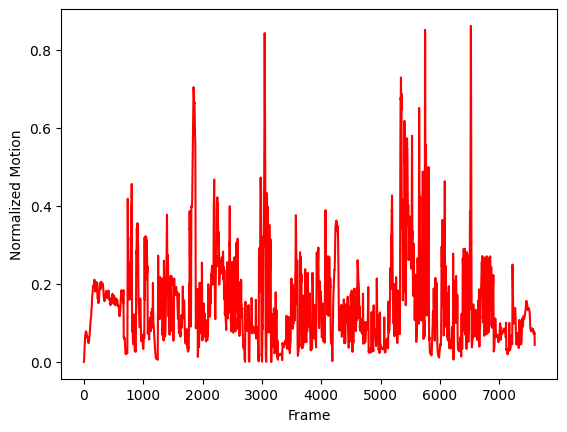

In [6]:
plt.plot(motion, 'r-')
plt.ylabel('Normalized Motion')
plt.xlabel('Frame')
plt.show()

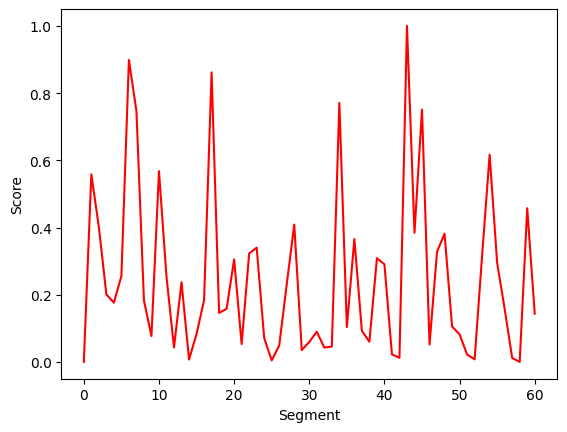

In [7]:
plt.plot(scores, 'r-')
plt.ylabel('Score')
plt.xlabel('Segment')
plt.show()

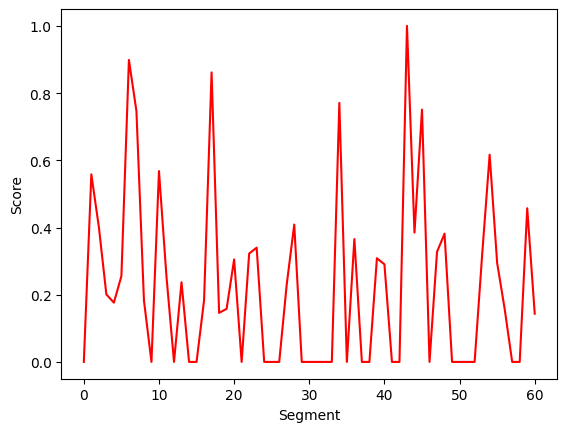

In [8]:
summScores = scores
summScores = np.where(summScores < 0.12, 0, summScores)

plt.plot(summScores, 'r-')
plt.ylabel('Score')
plt.xlabel('Segment')
plt.show()

In [9]:
segments = [idx for idx, val in enumerate(scores) if val > 0.12]
timeStamp_segments = [idx for idx, val in enumerate(scores) if val > 0.20]
print(segments)
print(timeStamp_segments)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 16, 17, 18, 19, 20, 22, 23, 27, 28, 34, 36, 39, 40, 43, 44, 45, 47, 48, 53, 54, 55, 56, 59, 60]
[1, 2, 3, 5, 6, 7, 10, 11, 13, 17, 20, 22, 23, 27, 28, 34, 36, 39, 40, 43, 44, 45, 47, 48, 53, 54, 55, 59]


In [10]:
def getTime(frame, videoFile):
    cap = cv2.VideoCapture(videoFile)
    fps = (cap.get(5))
    return (int) (frame / fps)

In [11]:
timeStamps = []
frameSegments = []
for i in segments:
    start = getTime(supers[i], "./videos/NYTravel.mp4")
    end = getTime(supers[i + 1], "./videos/NYTravel.mp4")
    timeStamps.append((start, end))
    frameSegments.append((supers[i], supers[i+1]))
    
timeStampsForTimeStamp = []
frameSegmentsForTimeStamp = []
for i in timeStamp_segments:
    start = getTime(supers[i], "./videos/NYTravel.mp4")
    end = getTime(supers[i + 1], "./videos/NYTravel.mp4")
    timeStampsForTimeStamp.append((start, end))
    frameSegmentsForTimeStamp.append((supers[i], supers[i+1]))
print(frameSegments)

[(125, 247), (247, 395), (395, 501), (501, 608), (608, 733), (733, 876), (876, 1003), (1003, 1128), (1245, 1367), (1367, 1509), (1627, 1759), (1997, 2125), (2125, 2235), (2235, 2377), (2377, 2517), (2517, 2622), (2768, 2884), (2884, 3003), (3373, 3482), (3482, 3607), (4270, 4387), (4483, 4646), (4878, 4983), (4983, 5128), (5376, 5515), (5515, 5641), (5641, 5740), (5858, 5984), (5984, 6134), (6628, 6748), (6748, 6876), (6876, 6983), (6983, 7143), (7369, 7482), (7482, 7598)]


In [12]:
def extractKeyFrames(final_arr, segmentNo, D, start, func):
    A = csc_matrix(final_arr, dtype=float)
    #top 63 singular values from 76082 to 508
    u, s, vt = svds(A, k = 63)
    
    v1_t = vt.transpose()
    projections = v1_t @ np.diag(s) #the column vectors i.e the frame histogram data has been projected onto the orthonormal basis 
    #formed by vectors of the left singular matrix u .The coordinates of the frames in this space are given by v1_t @ np.diag(s)
    #So we can see that , now we need only 63 dimensions to represent each column/frame 
    
    #dynamic clustering of projected frame histograms to find which all frames are similar i.e make shots
    f=projections
    C = dict() #to store frames in respective cluster
    for i in range(f.shape[0]):
        C[i] = np.empty((0,63), int)

    #adding first two projected frames in first cluster i.e Initializaton    
    C[0] = np.vstack((C[0], f[0]))   
    C[0] = np.vstack((C[0], f[1]))

    E = dict() #to store centroids of each cluster
    for i in range(projections.shape[0]):
        E[i] = np.empty((0,63), int)

    E[0] = np.mean(C[0], axis=0) #finding centroid of C[0] cluster

    count = 0
    for i in range(2,f.shape[0]):
        similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) 


        if similarity < 0.9: 

            count+=1         
            C[count] = np.vstack((C[count], f[i])) 
            E[count] = np.mean(C[count], axis=0)   
        else:  #if they are similar then assign this data point to last cluster formed and update the centroid of the cluster
            C[count] = np.vstack((C[count], f[i])) 
            E[count] = np.mean(C[count], axis=0)
            
    b = [] 

    for i in range(f.shape[0]):
        b.append(C[i].shape[0])

    last = b.index(0)  
    b1=b[:last ] #The size of each cluster.
    
    res = [idx for idx, val in enumerate(b1) if val >= 25] #so i am assuming any dense cluster with atleast 25 frames is eligible to make shot.
    
    GG = C 
    for i in range(last):
        p1= np.repeat(i, b1[i]).reshape(b1[i],1)
        GG[i] = np.hstack((GG[i],p1))
        
 
    F=  np.empty((0,64), int) 
    for i in range(last):
        F = np.vstack((F,GG[i]))
        
    #converting F (multidimensional array)  to dataframe
    colnames = []
    for i in range(1, 65):
        col_name = "v" + str(i)
        colnames+= [col_name]
    df = pd.DataFrame(F, columns= colnames)
    
    df['v64']= df['v64'].astype(int)  #converting the cluster level from float type to integer type
    
    df1 =  df[df.v64.isin(res)]   
    
    new = df1.groupby('v64').tail(1)['v64'] #For each cluster /group take its last element which summarize the shot i.e key-frame
    new1 = new.index #finding key-frames (frame number so that we can go back get the original picture)
    
    #output the frames in png format
    print(new)
    for c in new1:
        frame_rgb1 = cv2.cvtColor(D[c + start], cv2.COLOR_RGB2BGR) #since cv consider image in BGR order
        frame_num_chr = str(c + start)
        file_name = './keyFrames/'+str(func)+'/segment_'+str(segmentNo)+'_frame'+ frame_num_chr +'.png'
        cv2.imwrite(file_name, frame_rgb1)

In [13]:
def keyFrame(timeStamps, video, segmentNo, func):
    currFrame = 0
    cap = cv2.VideoCapture(video) 
    timeStampArr = []
    k = 0
    for i in timeStamps:
        k += 1
        start = i[0]
        end = i[1]
        arr = np.empty((0, 1944), int)   #initializing 1944 dimensional array to store 'flattened' color histograms
        D=dict()   #to store the original frame (array)
        count=0    #counting the number of frames
        start_time = time.time()
        while count <= end:
            while count < start:
                ret, frame = cap.read()
                count += 1

            # Read the video file.
            ret, frame = cap.read()

            # If we got frames.
            if ret == True:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  #since cv reads frame in bgr order so rearraning to get frames in rgb order
                D[count] = frame_rgb   #storing each frame (array) to D , so that we can identify key frames later 

                #dividing a frame into 3*3 i.e 9 blocks
                height, width, channels = frame_rgb.shape

                if height % 3 == 0:
                    h_chunk = int(height/3)
                else:
                    h_chunk = int(height/3) + 1

                if width % 3 == 0:
                    w_chunk = int(width/3)
                else:
                    w_chunk = int(width/3) + 1

                h=0
                w= 0 
                feature_vector = []
                for a in range(1,4):
                    h_window = h_chunk*a
                    for b in range(1,4):
                        frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                        hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])#finding histograms for each block  
                        hist1= hist.flatten()  #flatten the hist to one-dimensinal vector 
                        feature_vector += list(hist1)
                        w = w_chunk*b

                    h = h_chunk*a
                    w= 0


                arr =np.vstack((arr, feature_vector )) #appending each one-dimensinal vector to generate N*M matrix (where N is number of frames
                  #and M is 1944) 
                count+=1
            else:
                break
        
        print("Segment " + str(segmentNo))
        print("--- %s seconds ---" % (time.time() - start_time))

        final_arr = arr.transpose() #transposing so that i will have all frames in columns i.e M*N dimensional matrix 
        #where M is 1944 and N is number of frames
        print(final_arr.shape)
        extractKeyFrames(final_arr, segmentNo, D, start, func)

                

In [14]:
j = 0
for i in frameSegments[1:]:
    j += 1
    a = []
    a.append(i)
    keyFrame(a, "./videos/NYTravel.mp4", j, 'summ')

Segment 1
--- 1.3170702457427979 seconds ---
(1944, 149)
148    0
Name: v64, dtype: int32
Segment 2
--- 1.3954081535339355 seconds ---
(1944, 107)
106    0
Name: v64, dtype: int32
Segment 3
--- 1.604034423828125 seconds ---
(1944, 108)
107    0
Name: v64, dtype: int32
Segment 4
--- 1.958089828491211 seconds ---
(1944, 126)
125    0
Name: v64, dtype: int32
Segment 5
--- 2.3913559913635254 seconds ---
(1944, 144)
143    0
Name: v64, dtype: int32
Segment 6
--- 2.544734001159668 seconds ---
(1944, 128)
127    0
Name: v64, dtype: int32
Segment 7
--- 2.9182932376861572 seconds ---
(1944, 126)
125    0
Name: v64, dtype: int32
Segment 8
--- 3.4505341053009033 seconds ---
(1944, 123)
37     0
113    1
Name: v64, dtype: int32
Segment 9
--- 3.792090892791748 seconds ---
(1944, 143)
66     0
111    1
142    2
Name: v64, dtype: int32
Segment 10
--- 4.30578088760376 seconds ---
(1944, 133)
132    0
Name: v64, dtype: int32
Segment 11
--- 5.221060037612915 seconds ---
(1944, 129)
73     2
99     3
128

In [15]:
j = 0
for i in frameSegmentsForTimeStamp[1:]:
    j += 1
    a = []
    a.append(i)
    keyFrame(a, "./videos/NYTravel.mp4", j, 'time')

Segment 1
--- 1.2427663803100586 seconds ---
(1944, 149)
148    0
Name: v64, dtype: int32
Segment 2
--- 1.423598051071167 seconds ---
(1944, 107)
106    0
Name: v64, dtype: int32
Segment 3
--- 2.090714931488037 seconds ---
(1944, 126)
125    0
Name: v64, dtype: int32
Segment 4
--- 2.6540260314941406 seconds ---
(1944, 144)
143    0
Name: v64, dtype: int32
Segment 5
--- 2.581185817718506 seconds ---
(1944, 128)
127    0
Name: v64, dtype: int32
Segment 6
--- 3.413149356842041 seconds ---
(1944, 123)
37     0
113    1
Name: v64, dtype: int32
Segment 7
--- 3.677722215652466 seconds ---
(1944, 143)
66     0
111    1
142    2
Name: v64, dtype: int32
Segment 8
--- 4.699474096298218 seconds ---
(1944, 133)
132    0
Name: v64, dtype: int32
Segment 9
--- 5.283221006393433 seconds ---
(1944, 111)
110    1
Name: v64, dtype: int32
Segment 10
--- 6.056106805801392 seconds ---
(1944, 106)
105    0
Name: v64, dtype: int32
Segment 11
--- 6.6914660930633545 seconds ---
(1944, 117)
116    1
Name: v64, dt